In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pickle
import sys
from utils import utils
import numpy as np
import math

In [ ]:
#g = nx.read_edgelist("data/decoded.tsv")

#print(nx.info(g))
pd.read_csv('data/decoded.tsv', nrows=80, delimiter='\t').to_csv('data/decodedSample.tsv', sep='\t', header = False, index = False)

#reading the edgelist in a variable using networkX
subgraph = nx.read_edgelist('data/decodedSample.tsv', delimiter='\t', create_using=nx.DiGraph())
#plotting the graph
print(nx.info(subgraph))
pos=nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_color = '#A0CBE2', edge_color = '#00bb5e', width = 1, edge_cmap = plt.cm.Blues, with_labels = True)
plt.savefig("graph_sample.pdf")

In [ ]:
def generate_missing_edges(out_file, train_percent = 0.7):
    test_percent = 1 - train_percent
    r = pd.read_csv('data/decoded.tsv', delimiter = '\t', header = None)
    nrows = r.shape[0]
    removable_edges = random.sample(range(nrows), int(nrows*test_percent))    
    temp = r
    temp = temp.drop(removable_edges)
    csv = temp.to_csv('data/smaller_edgelist.tsv', sep='\t', index=False, index_label=False)
    pickle.dump(removable_edges,open(out_file, 'wb'))


In [ ]:
generate_missing_edges('data/removedEdgesList.pkl')

In [2]:
def random_forest_clf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    # print(clf.fit(X_train, y_train).summary())
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return [clf,acc,"Random Forest Classifier"]

def knn_clf(X, y, neighs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    clf = KNeighborsClassifier(n_neighbors = neighs)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return [clf,acc,"K-Nearest Neighbors"]

In [6]:
X = []
with open('data/X_data.pkl', 'rb') as f:
    X = pickle.load(f)
y = []
with open('data/Y_data.pkl', 'rb') as f:
    y = pickle.load(f)

In [12]:
classifiers = []

classifiers.append(random_forest_clf(X,y))
classifiers.append(knn_clf(X,y,int(math.sqrt(len(X)))))

In [14]:
print(classifiers[0][1])
print(classifiers[1][1])

0.9705609436768313
0.7775546262282163


In [15]:
rm_edges = []
with open('data/removedEdgesList.pkl', 'rb') as f:
    rm_edges = pickle.load(f)

# Load original network
G = nx.read_edgelist('data/decoded.tsv', delimiter = '\t', create_using=nx.DiGraph())

# Load smaller network
S = nx.read_edgelist('data/smaller_edgelist.tsv', delimiter = '\t', create_using=nx.DiGraph())

utils.HITS(S, 'data/smaller_hits.pkl')
utils.PR_file(S, 'data/smaller_pr.pkl')

pr = []
with open('data/smaller_pr.pkl', 'rb') as f:
    pr = pickle.load(f)

hits = []
with open('data/smaller_hits.pkl', 'rb') as f:
    hits = pickle.load(f)

cat_dict = []
with open('data/getCategoryFromLinkDict.pkl', 'rb') as f:
    cat_dict = pickle.load(f)

In [16]:
vecs = []
scores = []
for e in G.edges():
    u, v = e
    a = list(utils.create_X(S,u,v, cat_dict,pr,hits))
    vec = np.array(a)
    vecs.append(vec)

y_predsRF = classifiers[0][0].predict(vecs)
y_predsKNN = classifiers[1][0].predict(vecs)

scoreRF = accuracy_score(np.ones(len(G.edges)), y_predsRF)
scoreKNN = accuracy_score(np.ones(len(G.edges)), y_predsKNN)
scores.append(scoreRF)
scores.append(scoreKNN)
print(scores)

[0.9474232995779183, 0.6047947148028895]


In [22]:
# Calculate feature importances

for i in range(1):
    print("For", classifiers[i][2])
    feature_importances = list(classifiers[i][0].feature_importances_)
    feature_list = list(["no_comm", "jd", "aa", "pr_x", "pr_y", "hits_x", "hits_y"])
    f_importances = [(feature, round(feature_importance, 2)) for feature, feature_importance in zip(feature_list, feature_importances)]
    # Sort the feature importances by most important first
    f_importances = sorted(f_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in f_importances]
    print('\n')



For Random Forest Classifier
Variable: hits_y               Importance: 0.26
Variable: aa                   Importance: 0.21
Variable: pr_y                 Importance: 0.21
Variable: jd                   Importance: 0.17
Variable: hits_x               Importance: 0.07
Variable: no_comm              Importance: 0.04
Variable: pr_x                 Importance: 0.04




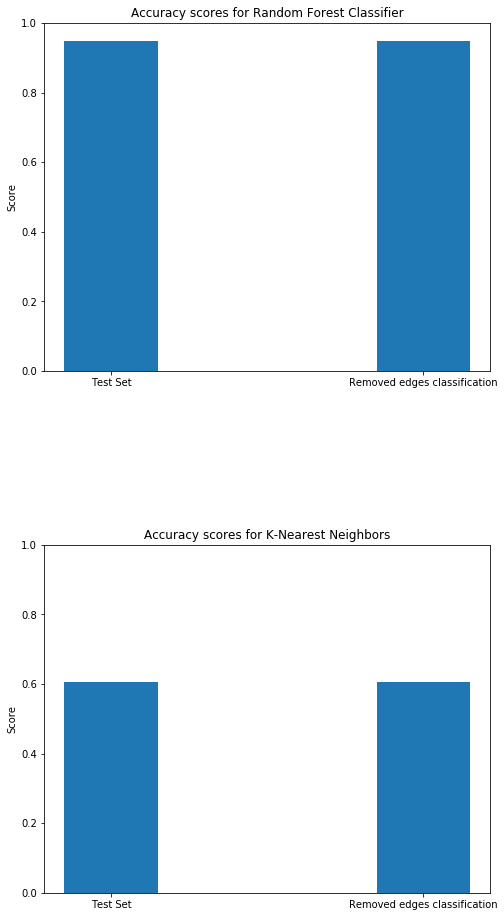

In [39]:
fig, ax = plt.subplots(2,1, figsize=(8, 16))
fig.subplots_adjust(hspace=0.5)
i=0
labels =['Test Set', 'Removed edges classification']

for clf in classifiers:
    
    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    bars = ax[i].bar(x, scores[i], width)

    ax[i].set_ylabel('Score')
    ax[i].set_ylim([0,1])
    ax[i].set_title('Accuracy scores for ' + str(clf[2]))
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)
    i = i+1
plt.draw()